Тема нашего проекта **"Риски - Построение заявочной модели по физическим лицам (Application scoring model)"**.

Данные: https://www.kaggle.com/competitions/home-credit-default-risk/data

Наша команда предлагает следующий план работы:

1. Описание датасета (brief)
2. Сделать Explanatory Data Analysis
3. Data Engineering
4. Решить проблему с несбалансированностью датасета несколькими способами
5. Выбрать несколько метрик
6. Выбрать различные модели. Затем построить модели на одобренных заявках
7. Оценить метрики моделей, сделать выводы и как можно будет реализовать финальную модель в бизнесе

Распределение задач:
Пункты 1-5 и 7 являются общими, а остальные пункты являются индивидуальными в зависимости от выбранной модели, которую каждый член команды выберет себе. У нас будет упор на реализацию модели и дальнейшую оптимизацию(гиперпараметры). Каждый член команды будет ответственен за свою модель прогноза.

Сроки выполнения:
1. пункт - 1-2 дня
2. пункт - 1-2 дня
3. пункт - 2-3 дня
4. пункт - 2-3 дня
5. пункт - 7 дней
6. пункт - 7-10 дней
7. пункт - 3-4 дня

Результаты:
1. Кратко описать датасет
2. Получить информацию о датасете (посмотреть на число пропусков; посмотреть на категориальные переменные; посмотреть долю таргетной переменной(сбалансированный или нет))
3. Удаление/замена пустых значений; категориальные переменные - при необходимости заменить их на количественные/придумать новые переменные;min-max нормализация и PCA
4. Посмотреть на распределение классов: если сбалансированное, то все ок; если нет - использовать алгоритмы для несбалансированного датасета
5. Метрика F1 точно используется, так как нужна проверка на сбалансированный датасет. И ещё ROC-AUC
6. Использованы различные модели с train/test выборками в пропорции 70/30.Получаем главный результат работы и пытаемся проанализировать и интерпретировать его с помощью метрик
7. Обосновать практическое применение

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from tabulate import tabulate                    #allows to represent information in table format
pd.set_option("display.max_columns", None)       #this allows to show all possible columns

# Пункт 1 - Brief Introduction

In this part, we will take an initial look at the Home Credit default risk machine learning competition that was hosted on Kaggle. The objective of this competition is to use historical loan application data to predict whether or not an applicant will be able to repay a loan. This is a standard **supervised classification task**:

*Supervised*: The labels are included in the training data and the goal is to train a model to learn to predict the labels from the features
*Classification*: The label is a binary variable, 0 (will repay loan on time), 1 (will have difficulty repaying loan)

**Data**

The data is provided by Home Credit, a service dedicated to provided lines of credit (loans) to the unbanked population. Predicting whether or not a client will repay a loan or have difficulty is a critical business need, and Home Credit is hosting this competition on Kaggle to see what sort of models the machine learning community can develop to help them in this task.

Firstly, we can list all the available data files. There are a total of 10 files: 1 main file for training (with target), 1 main file for testing (without the target), 1 example submission file, 1 file with descriptions and 6 other files containing additional information about each loan.

There are 7 different sources of data:

Dataset Description

1. application_{train|test}.csv

*   This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
*   Static data for all applications. One row represents one loan in our data sample.

2. bureau.csv

*   All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
*   For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

3. bureau_balance.csv

*   Monthly balances of previous credits in Credit Bureau.
*   This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

4. POS_CASH_balance.csv

*   Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
*   This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

5. credit_card_balance.csv

*   Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
*   This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

6. previous_application.csv

*   All previous applications for Home Credit loans of clients who have loans in our sample.
*   There is one row for each previous application related to loans in our data sample.

7. installments_payments.csv

*   Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
*   There is a) one row for every payment that was made plus b) one row each for missed payment.
*   One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

This diagram shows how all of the data is related:

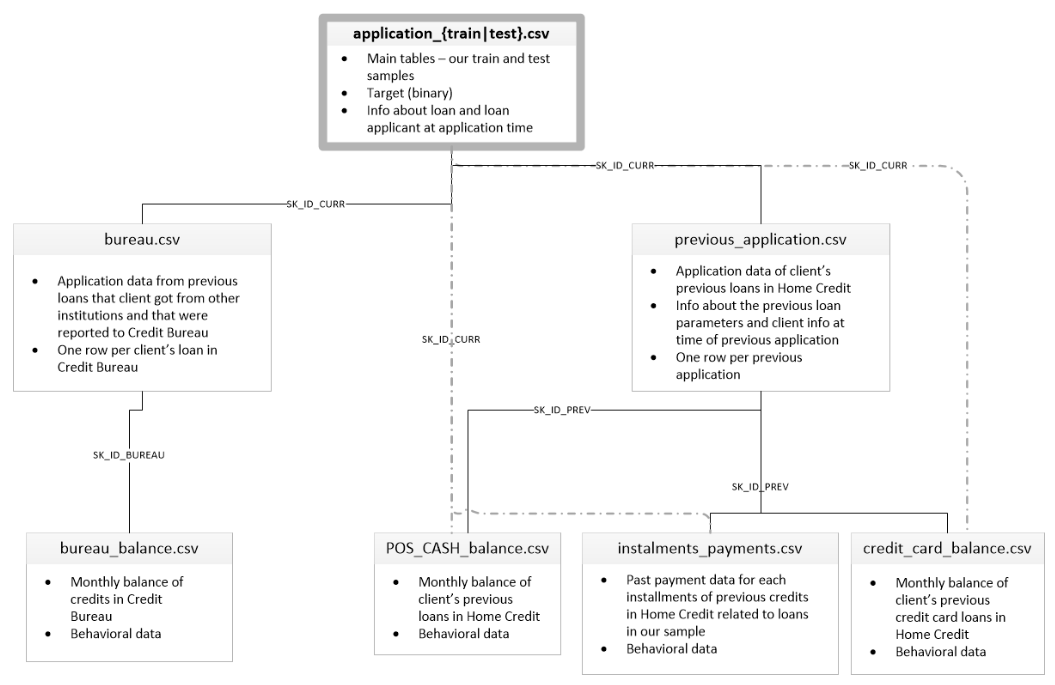

In [ ]:
train = pd.read_csv("application_train.csv", sep=",")
test = pd.read_csv("application_test.csv", sep=",")

In [ ]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [ ]:
train.shape

(307511, 122)

The training data has 307511 observations (each one a separate loan) and 122 features (variables) including the TARGET (the label we want to predict).

In [ ]:
test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married

In [ ]:
test.shape

(48744, 121)

The test dataset is considerably smaller(48744 observations) and lacks a TARGET column.

# Пункт 2 - Explatory Data Analysis

Let's take a more detailed look at the data. It would be a good idea to look at the correlation between the variables.

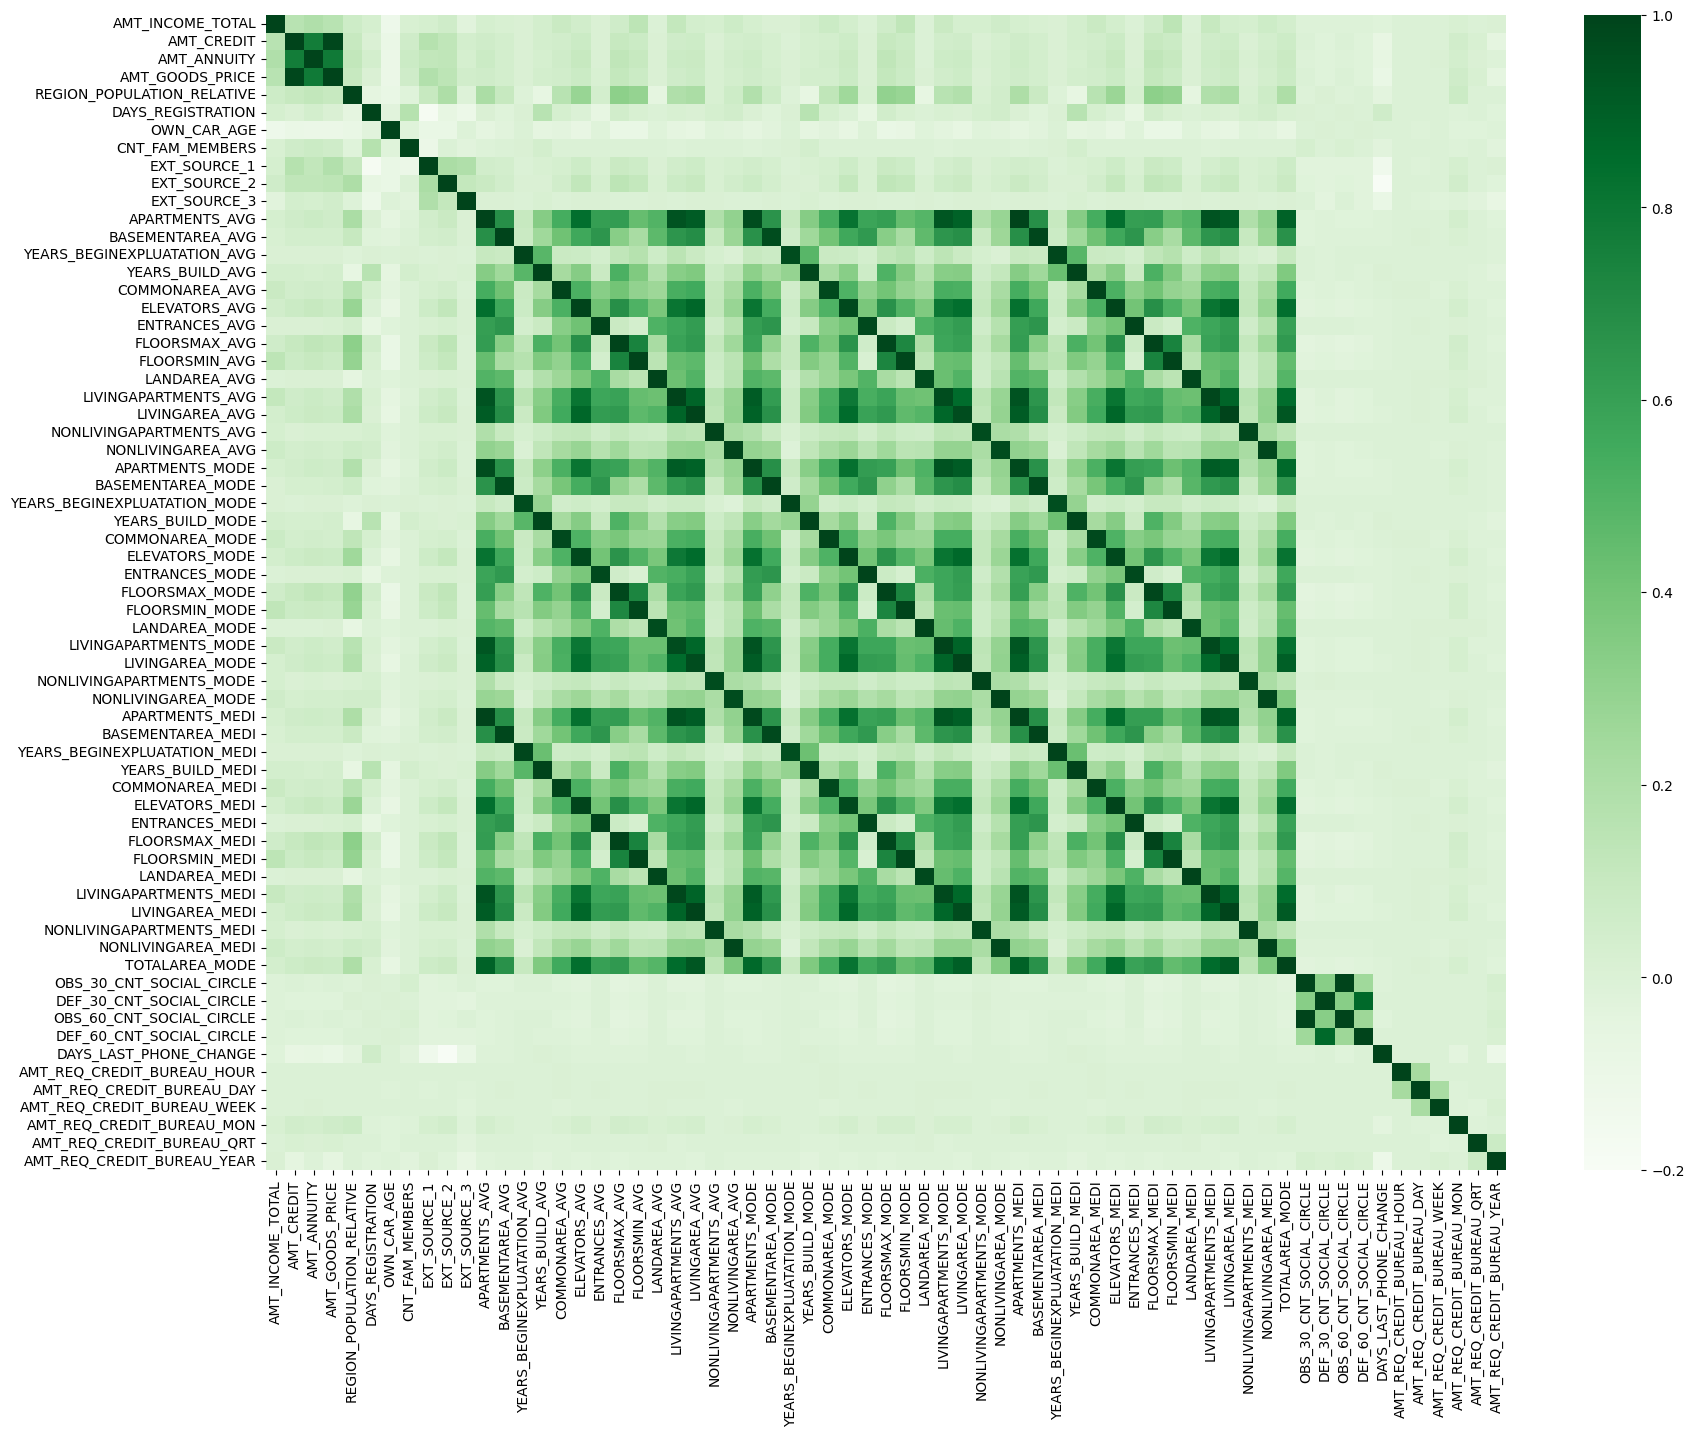

In [ ]:
fig = plt.figure(figsize = (20,15))
sns.heatmap(round(train.select_dtypes(include="float64").corr(), 2), cmap="Greens")
plt.show()


As it can be seen, there are three the most prominent parts of the correlation table.

1) The combination of AMT_CREDIT, AMT_ANNUITY and AMT_GOODS_PRICE. The correlation here is pretty high. These variables represent specific information about the client: income, credit amount and loan annuity. Such correlation is probably due to close interconnections between variables.

2) The combination of variables starting from APARTMENTS_AVG and finishing by TOTALAREA_MODE. The correlation here is outstanding and at the same time chaotically specific for certain variables. Such correlation is probably due to the fact that the specified boundaries of variables are all connected with the building where the client lives meaning close interconnections between values.

3) The combination of OBS_30_CNT_SOCIAL_CIRCLE, DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE and DEF_60_CNT_SOCIAL_CIRCLE. The correlation here is quite high. These variables represent how many observation of client's social surroundings defaulted or will default on 30 DPD (days past due) or 60DPD. Such correlation is probably due to close interconnections between variables that makes variable OBS_60_CNT_SOCIAL_CIRCLE includes the values of variable OBS_30_CNT_SOCIAL_CIRCLE(the same for DEF_60_CNT_SOCIAL_CIRCLE and DEF_30_CNT_SOCIAL_CIRCLE).

Next step is calculation of the number of unique, null and empty values + their share in % of the total number, data type of each variable.

In [ ]:
def columnValues(df):
    row = [df.nunique(), round(df.nunique()*100/len(df), 1), (df==0).sum(axis=0), round((df==0).sum(axis=0)*100/len(df), 1), \
                                                            df.isna().sum(), round(df.isna().sum()*100/len(df), 1), df.dtypes]
    return row

table = []
for column in train:
    table.append([column] + columnValues(train[column]))

print(tabulate(table, headers=["Column","Count Unique", "% of unique","Count Zeros", "% of zeros", "Count NAs","% of NAs","Data type"], tablefmt="orgbtl"))

Column                          Count Unique    % of unique    Count Zeros    % of zeros    Count NAs    % of NAs  Data type
----------------------------  --------------  -------------  -------------  ------------  -----------  ----------  -----------
SK_ID_CURR                            307511          100                0           0              0         0    int64
TARGET                                     2            0           282686          91.9            0         0    int64
NAME_CONTRACT_TYPE                         2            0                0           0              0         0    object
CODE_GENDER                                3            0                0           0              0         0    object
FLAG_OWN_CAR                               2            0                0           0              0         0    object
FLAG_OWN_REALTY                            2            0                0           0              0         0    object
CNT_CHILDREN      

As it was previously found, we have 118388 observations in train dataset. Column SK_ID_CURR also suggests that we have 118388 observations.

Some important moments:

*   The proportion of empty values is quite considerable for a dataset with 118388 rows. The maximum proportion of NAs exceeds 69.9%
*   The proportion of null values is very variable so for example most of the FLAG_DOCUMENT variables can have about 100% null values. Our TARGET variable is 91.8% null, because it takes values of either 1 or 0. 37 variables from our training data have no null values at all, and the rest varies on average from 17% to 90%
*   Our dataset contains only 11 object variables out of total 122.
*   The variable CODE_GENDER contains three unique values and we found out later that there is one extra one called XNA


Also, there will be calculation of mean, median, standard deviation, minimum, maximum. Generally, following table is for numeric variables only.

In [ ]:
def columnValues(df):
    row = [df.mean(), df.median(), df.std(), df.min(), df.max()]
    return row

table = []
for column in train.select_dtypes(include=np.number):
    table.append([column] + columnValues(train[column]))

print(tabulate(table, headers=["Column","Mean","Median","Std","Min","Max"], tablefmt="orgbtl"))

Column                                    Mean         Median              Std               Min            Max
----------------------------  ----------------  -------------  ---------------  ----------------  -------------
SK_ID_CURR                    278181            278202         102790           100002            456255
TARGET                             0.0807288         0              0.272419         0                 1
CNT_CHILDREN                       0.417052          0              0.722121         0                19
AMT_INCOME_TOTAL              168798            147150         237123            25650                 1.17e+08
AMT_CREDIT                    599026            513531         402491            45000                 4.05e+06
AMT_ANNUITY                    27108.6           24903          14493.7           1615.5          258026
AMT_GOODS_PRICE               538396            450000         369446            40500                 4.05e+06
REGION_POPULATION_RE

Interestingly, we found that there are negative values that are acceptable for analysis(DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE).

Target distribution

In [ ]:
train.TARGET.value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

Here we will examine the distribution of data by categorical variables.

Namely:

*   TARGET (there is approximately 92% clients with no payment difficulties)
*   CODE_GENDER (there is approximately 2-fold difference between quantity of men and women, also there is an extra XNA variable)
*   NAME_CONTRACT_TYPE (Cash loans are the most popular type of contract)
*   FLAG_OWN_CAR (there is approximately 2-fold difference between having car and no car)
*   FLAG_OWN_REALTY (there is approximately 2-fold difference between having own house or flat and no own)
*   CNT_CHILDREN (Most clients don't have children)



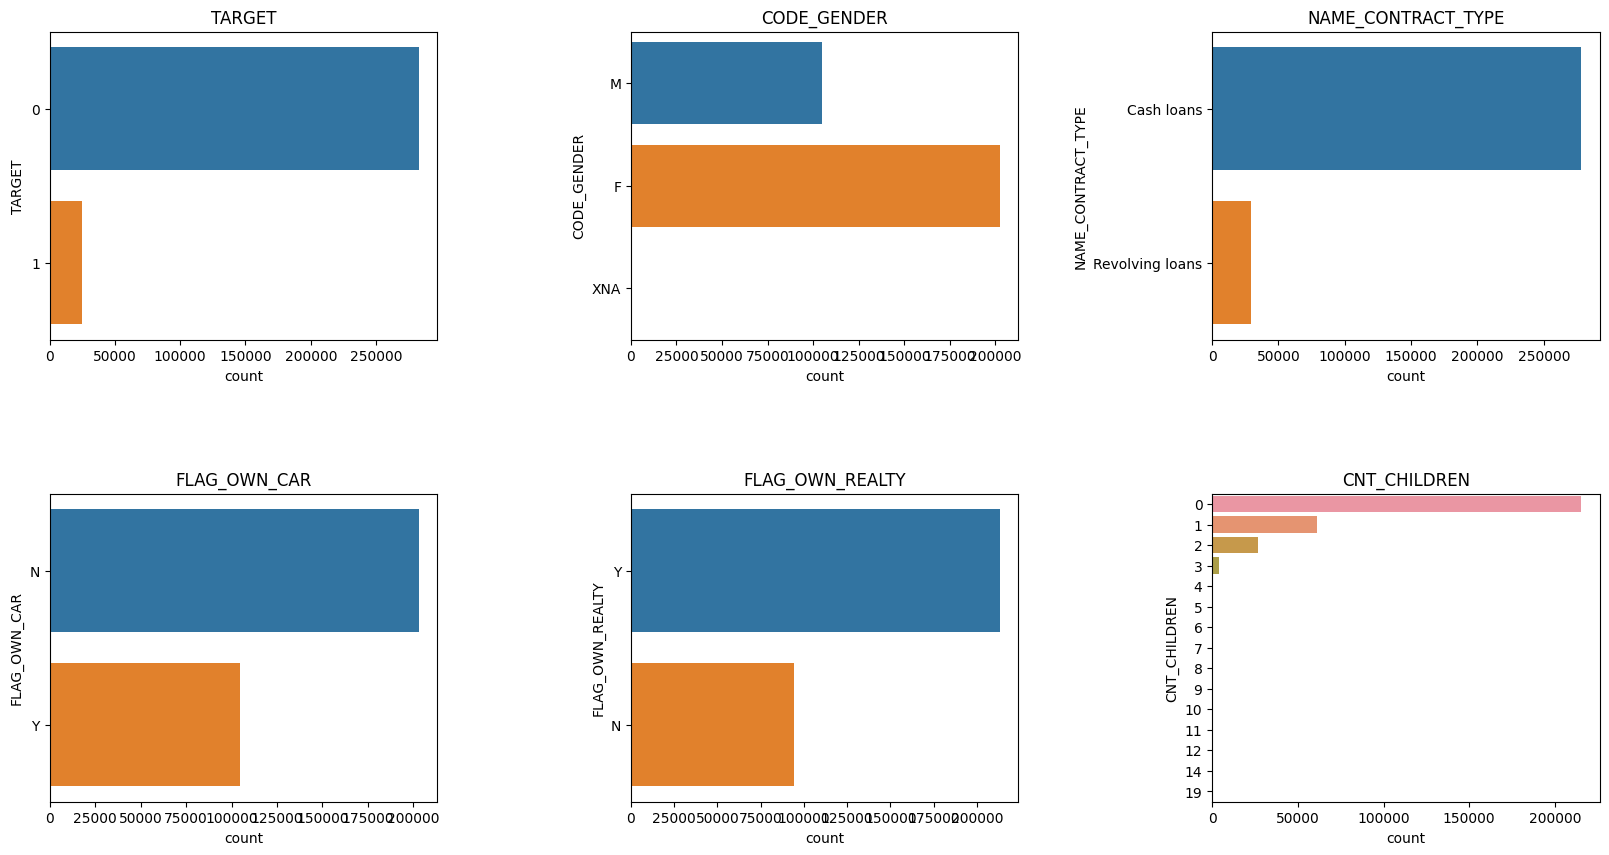

In [ ]:
plt.figure(figsize=(20, 10))

plt.subplot(2, 3, 1)
sns.countplot(y='TARGET', data=train)
plt.title("TARGET")

plt.subplot(2, 3, 2)
sns.countplot(y='CODE_GENDER', data=train)
plt.title("CODE_GENDER")

plt.subplot(2, 3, 3)
sns.countplot(y='NAME_CONTRACT_TYPE', data=train)
plt.title("NAME_CONTRACT_TYPE")

plt.subplot(2, 3, 4)
sns.countplot(y='FLAG_OWN_CAR', data=train)
plt.title("FLAG_OWN_CAR")

plt.subplot(2, 3, 5)
sns.countplot(y='FLAG_OWN_REALTY', data=train)
plt.title("FLAG_OWN_REALTY")

plt.subplot(2, 3, 6)
sns.countplot(y='CNT_CHILDREN', data=train)
plt.title("CNT_CHILDREN")

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

Now we will examine the distribution of data by numerical variables.

Namely:

*   AMT_INCOME_TOTAL
*   AMT_CREDIT
*   AMT_ANNUITY
*   AMT_GOODS_PRICE
*   DAYS_EMPLOYED
*   REGION_POPULATION_RELATIVE



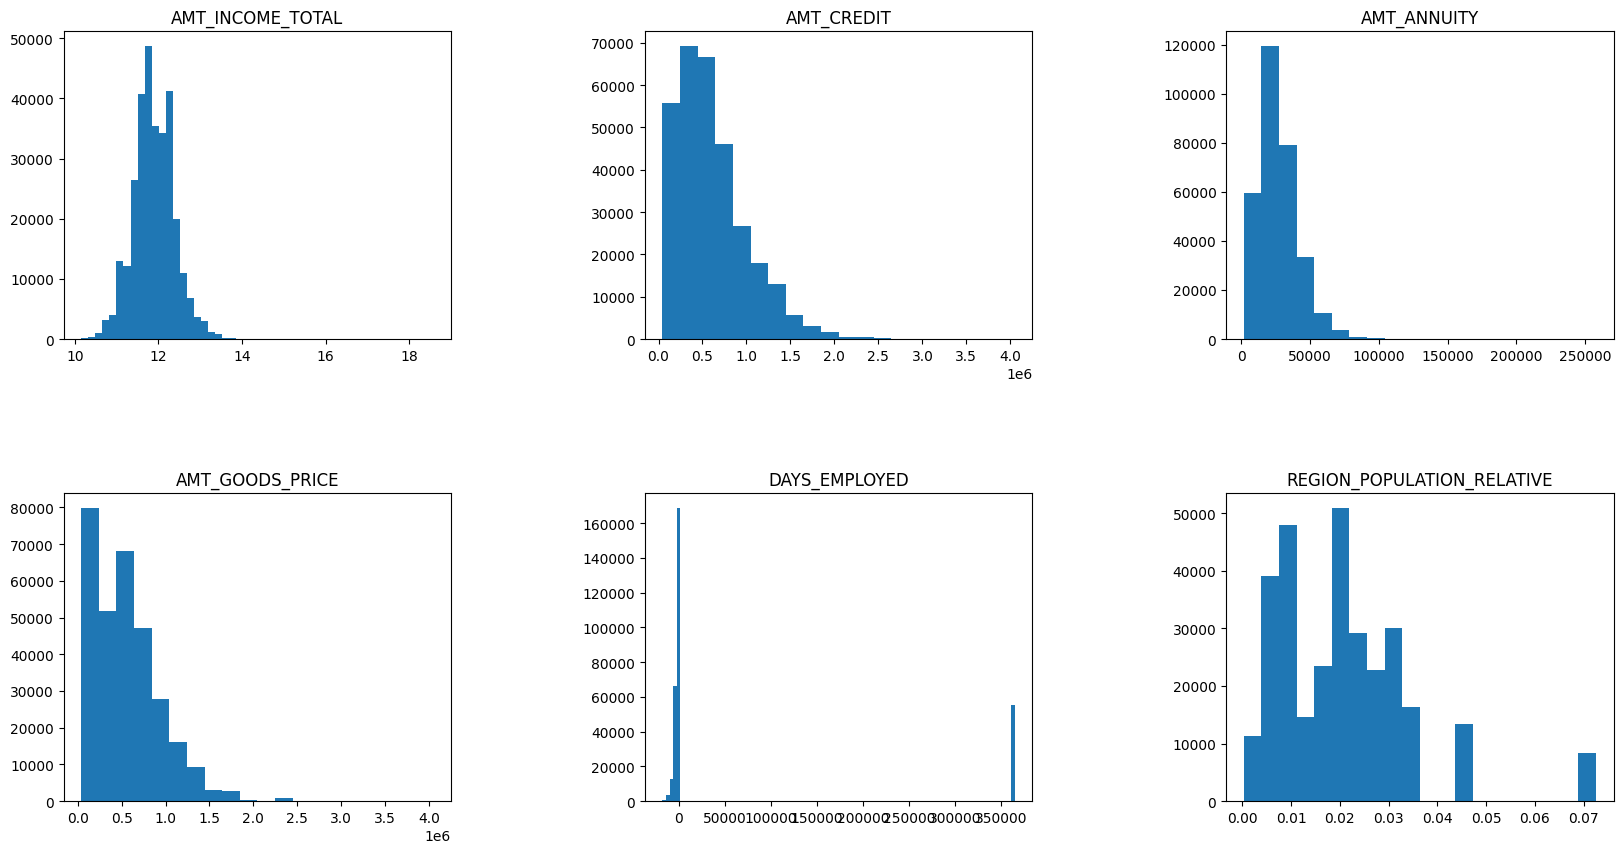

In [ ]:
plt.figure(figsize=(20, 10))

plt.subplot(2, 3, 1)
plt.hist(np.log(train["AMT_INCOME_TOTAL"]), bins = 50)
plt.title("AMT_INCOME_TOTAL")

plt.subplot(2, 3, 2)
plt.hist(train["AMT_CREDIT"], bins = 20)
plt.title("AMT_CREDIT")

plt.subplot(2, 3, 3)
plt.hist(train["AMT_ANNUITY"], bins = 20)
plt.title("AMT_ANNUITY")

plt.subplot(2, 3, 4)
plt.hist(train["AMT_GOODS_PRICE"], bins = 20)
plt.title("AMT_GOODS_PRICE")

plt.subplot(2, 3, 5)
plt.hist(train["DAYS_EMPLOYED"], bins = 100)
plt.title("DAYS_EMPLOYED")

plt.subplot(2, 3, 6)
plt.hist(train["REGION_POPULATION_RELATIVE"], bins = 20)
plt.title("REGION_POPULATION_RELATIVE")

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

The most of these variables follows normal distribution.

Namely:

*   AMT_INCOME_TOTAL
*   AMT_CREDIT
*   AMT_ANNUITY
*   AMT_GOODS_PRICE

DAYS_EMPLOYED has one outlier.




# Пункт 3 - Data Engineering

In [ ]:
df = train

## Feature Engineering

After looking at distribution of categorical and numerical variables we will deal with null values and empty values by dropping them or imputing mean or median(it is possible if no more than 20% of the column's data is missing.

In [ ]:
df['CODE_GENDER'].unique()

array(['M', 'F', 'XNA'], dtype=object)

In [ ]:
df['NAME_HOUSING_TYPE'].unique()

array(['House / apartment', 'Rented apartment', 'With parents',
       'Municipal apartment', 'Office apartment', 'Co-op apartment'],
      dtype=object)

In [ ]:
df['NAME_FAMILY_STATUS'].unique()

array(['Single / not married', 'Married', 'Civil marriage', 'Widow',
       'Separated', 'Unknown'], dtype=object)

In [ ]:
df['NAME_INCOME_TYPE'].unique()

array(['Working', 'State servant', 'Commercial associate', 'Pensioner',
       'Unemployed', 'Student', 'Businessman', 'Maternity leave'],
      dtype=object)

In [ ]:
df['NAME_EDUCATION_TYPE'].unique()

array(['Secondary / secondary special', 'Higher education',
       'Incomplete higher', 'Lower secondary', 'Academic degree'],
      dtype=object)

In [ ]:
df['OCCUPATION_TYPE'].unique()

array(['Laborers', 'Core staff', 'Accountants', 'Managers', nan,
       'Drivers', 'Sales staff', 'Cleaning staff', 'Cooking staff',
       'Private service staff', 'Medicine staff', 'Security staff',
       'High skill tech staff', 'Waiters/barmen staff',
       'Low-skill Laborers', 'Realty agents', 'Secretaries', 'IT staff',
       'HR staff'], dtype=object)

In [ ]:
df['ORGANIZATION_TYPE'].unique()

array(['Business Entity Type 3', 'School', 'Government', 'Religion',
       'Other', 'XNA', 'Electricity', 'Medicine',
       'Business Entity Type 2', 'Self-employed', 'Transport: type 2',
       'Construction', 'Housing', 'Kindergarten', 'Trade: type 7',
       'Industry: type 11', 'Military', 'Services', 'Security Ministries',
       'Transport: type 4', 'Industry: type 1', 'Emergency', 'Security',
       'Trade: type 2', 'University', 'Transport: type 3', 'Police',
       'Business Entity Type 1', 'Postal', 'Industry: type 4',
       'Agriculture', 'Restaurant', 'Culture', 'Hotel',
       'Industry: type 7', 'Trade: type 3', 'Industry: type 3', 'Bank',
       'Industry: type 9', 'Insurance', 'Trade: type 6',
       'Industry: type 2', 'Transport: type 1', 'Industry: type 12',
       'Mobile', 'Trade: type 1', 'Industry: type 5', 'Industry: type 10',
       'Legal Services', 'Advertising', 'Trade: type 5', 'Cleaning',
       'Industry: type 13', 'Trade: type 4', 'Telecom',
       'I

Surprisingly, we have specific value "XNA" in columns "CODE_GENDER" and "ORGANIZATION_TYPE". Also, category "Unknown" in column "NAME_FAMILY_STATUS". They will be changed to NaN for better processing of the data.

In [ ]:
df.replace("XNA", np.NaN, inplace = True)
df.replace("Unknown", np.NaN, inplace = True)

As it was mentioned above about almost 70% sparsity of dataframe is presented, it would better to drop these rows because imputation will lead to biasedness and these 70% most probably will disappear in every most affected columns.

In [ ]:
df = df.dropna(axis=0, subset=['COMMONAREA_AVG'])

In [ ]:
def columnValues(df):
    row = [df.nunique(), round(df.nunique()*100/len(df), 1), (df==0).sum(axis=0), round((df==0).sum(axis=0)*100/len(df), 1), \
                                                            df.isna().sum(), round(df.isna().sum()*100/len(df), 1), df.dtypes]
    return row

table = []
for column in df:
    table.append([column] + columnValues(df[column]))

print(tabulate(table, headers=["Column","Count Unique", "% of unique","Count Zeros", "% of zeros", "Count NAs","% of NAs","Data type"], tablefmt="orgbtl"))

Column                          Count Unique    % of unique    Count Zeros    % of zeros    Count NAs    % of NAs  Data type
----------------------------  --------------  -------------  -------------  ------------  -----------  ----------  -----------
SK_ID_CURR                             92646          100                0           0              0         0    int64
TARGET                                     2            0            86244          93.1            0         0    int64
NAME_CONTRACT_TYPE                         2            0                0           0              0         0    object
CODE_GENDER                                2            0                0           0              1         0    object
FLAG_OWN_CAR                               2            0                0           0              0         0    object
FLAG_OWN_REALTY                            2            0                0           0              0         0    object
CNT_CHILDREN      

Next step is imputation by mean or median. It is possible because the number of missing values is not so big(20% is the upper limit). Also, NAs in categorical variables will be dropped because there is no right way to impute categorical value and their deletion will not affect general picture.

In [ ]:
df['OBS_30_CNT_SOCIAL_CIRCLE'].fillna(float(df['OBS_30_CNT_SOCIAL_CIRCLE'].median()), inplace=True)
df['OBS_60_CNT_SOCIAL_CIRCLE'].fillna(float(df['OBS_60_CNT_SOCIAL_CIRCLE'].median()), inplace=True)
df['DEF_30_CNT_SOCIAL_CIRCLE'].fillna(float(df['DEF_30_CNT_SOCIAL_CIRCLE'].median()), inplace=True)
df['DEF_60_CNT_SOCIAL_CIRCLE'].fillna(float(df['DEF_60_CNT_SOCIAL_CIRCLE'].median()), inplace=True)
df.drop(["OWN_CAR_AGE"], axis = 1, inplace=True)     # 67% of missing values
df.drop(["EXT_SOURCE_1"], axis = 1, inplace=True)    # 53.4% of missing values
df.drop(["OCCUPATION_TYPE"], axis = 1, inplace=True) # 31.5% of missing values
df.drop(["FLAG_MOBIL"], axis = 1, inplace=True)     # 100% inaccurate values
df = df.astype({"TOTALAREA_MODE": float}) # needed to be changed to float
for column in df.select_dtypes(include=np.number):
    df[column] = df[column].fillna(float(df[column].mean()))
df.dropna(inplace=True)

In [ ]:
def columnValues(df):
    row = [df.nunique(), round(df.nunique()*100/len(df), 1), (df==0).sum(axis=0), round((df==0).sum(axis=0)*100/len(df), 1), \
                                                            df.isna().sum(), round(df.isna().sum()*100/len(df), 1), df.dtypes]
    return row

table = []
for column in df:
    table.append([column] + columnValues(df[column]))

print(tabulate(table, headers=["Column","Count Unique", "% of unique","Count Zeros", "% of zeros", "Count NAs","% of NAs","Data type"], tablefmt="orgbtl"))

Column                          Count Unique    % of unique    Count Zeros    % of zeros    Count NAs    % of NAs  Data type
----------------------------  --------------  -------------  -------------  ------------  -----------  ----------  -----------
SK_ID_CURR                             71400          100                0           0              0           0  int64
TARGET                                     2            0            66113          92.6            0           0  int64
NAME_CONTRACT_TYPE                         2            0                0           0              0           0  object
CODE_GENDER                                2            0                0           0              0           0  object
FLAG_OWN_CAR                               2            0                0           0              0           0  object
FLAG_OWN_REALTY                            2            0                0           0              0           0  object
CNT_CHILDREN      

The final step is to hot-encode categorical feature in order to make them numeric. Also, categorical variables like CODE_GENDER are binary encoded.

In [ ]:
df['CODE_GENDER'] = df['CODE_GENDER'].replace({'F' : 0, 'M' : 1}) # female = 0; male = 1
df['FLAG_OWN_CAR'] = df['FLAG_OWN_CAR'].replace({'Y' : 1, 'N' : 0}) # yes = 1; no = 0
df['FLAG_OWN_REALTY'] = df['FLAG_OWN_REALTY'].replace({'Y' : 1, 'N' : 0}) # yes = 1; no = 0
df['EMERGENCYSTATE_MODE'] = df['EMERGENCYSTATE_MODE'].replace({'Yes' : 1, 'No' : 0}) # yes = 1; no = 0

df = pd.get_dummies(df, columns=['EMERGENCYSTATE_MODE', 'NAME_CONTRACT_TYPE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', \
                                 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'FONDKAPREMONT_MODE', \
                                 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', "ORGANIZATION_TYPE"], drop_first = True)

## Extra Features Creation

We need to make more feautures in order to improve our results

In [ ]:
df['credit_to_income_ratio'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
df['days_employed_percentage'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
df['income_per_person'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
df['non_child_count'] = df['CNT_FAM_MEMBERS'] - df['CNT_CHILDREN']

## Test Engineering

Let us make the same procedure with test data

In [ ]:
def columnValues(df):
    row = [df.nunique(), round(df.nunique()*100/len(df), 1), (df==0).sum(axis=0), round((df==0).sum(axis=0)*100/len(df), 1), \
                                                            df.isna().sum(), round(df.isna().sum()*100/len(df), 1), df.dtypes]
    return row

table = []
for column in test:
    table.append([column] + columnValues(test[column]))

print(tabulate(table, headers=["Column","Count Unique", "% of unique","Count Zeros", "% of zeros", "Count NAs","% of NAs","Data type"], tablefmt="orgbtl"))

Column                          Count Unique    % of unique    Count Zeros    % of zeros    Count NAs    % of NAs  Data type
----------------------------  --------------  -------------  -------------  ------------  -----------  ----------  -----------
SK_ID_CURR                             48744          100                0           0              0         0    int64
NAME_CONTRACT_TYPE                         2            0                0           0              0         0    object
CODE_GENDER                                2            0                0           0              0         0    object
FLAG_OWN_CAR                               2            0                0           0              0         0    object
FLAG_OWN_REALTY                            2            0                0           0              0         0    object
CNT_CHILDREN                              11            0            34685          71.2            0         0    int64
AMT_INCOME_TOTAL  

In [ ]:
test.replace("XNA", np.NaN, inplace = True)
test.replace("Unknown", np.NaN, inplace = True)
test = test.dropna(axis=0, subset=['COMMONAREA_AVG'])

test['OBS_30_CNT_SOCIAL_CIRCLE'].fillna(float(test['OBS_30_CNT_SOCIAL_CIRCLE'].median()), inplace=True)
test['OBS_60_CNT_SOCIAL_CIRCLE'].fillna(float(test['OBS_60_CNT_SOCIAL_CIRCLE'].median()), inplace=True)
test['DEF_30_CNT_SOCIAL_CIRCLE'].fillna(float(test['DEF_30_CNT_SOCIAL_CIRCLE'].median()), inplace=True)
test['DEF_60_CNT_SOCIAL_CIRCLE'].fillna(float(test['DEF_60_CNT_SOCIAL_CIRCLE'].median()), inplace=True)
test.drop(["OWN_CAR_AGE"], axis = 1, inplace=True)     # 67% of missing values
test.drop(["EXT_SOURCE_1"], axis = 1, inplace=True)    # 53.4% of missing values
test.drop(["OCCUPATION_TYPE"], axis = 1, inplace=True) # 31.5% of missing values
test.drop(["FLAG_MOBIL"], axis = 1, inplace=True)
test = test.astype({"TOTALAREA_MODE": float}) # needed to be changed to float
for column in test.select_dtypes(include=np.number):
    test[column] = test[column].fillna(float(test[column].mean()))
test.dropna(inplace=True)

test['CODE_GENDER'] = test['CODE_GENDER'].replace({'F' : 0, 'M' : 1}) # female = 0; male = 1
test['FLAG_OWN_CAR'] = test['FLAG_OWN_CAR'].replace({'Y' : 1, 'N' : 0}) # yes = 1; no = 0
test['FLAG_OWN_REALTY'] = test['FLAG_OWN_REALTY'].replace({'Y' : 1, 'N' : 0}) # yes = 1; no = 0
test['EMERGENCYSTATE_MODE'] = test['EMERGENCYSTATE_MODE'].replace({'Yes' : 1, 'No' : 0}) # yes = 1; no = 0

test = pd.get_dummies(test, columns=['EMERGENCYSTATE_MODE', 'NAME_CONTRACT_TYPE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', \
                                 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'FONDKAPREMONT_MODE', \
                                 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', "ORGANIZATION_TYPE"], drop_first = True)

In [ ]:
def columnValues(df):
    row = [df.nunique(), round(df.nunique()*100/len(df), 1), (df==0).sum(axis=0), round((df==0).sum(axis=0)*100/len(df), 1), \
                                                            df.isna().sum(), round(df.isna().sum()*100/len(df), 1), df.dtypes]
    return row

table = []
for column in test:
    table.append([column] + columnValues(test[column]))

print(tabulate(table, headers=["Column","Count Unique", "% of unique","Count Zeros", "% of zeros", "Count NAs","% of NAs","Data type"], tablefmt="orgbtl"))

Column                                               Count Unique    % of unique    Count Zeros    % of zeros    Count NAs    % of NAs  Data type
-------------------------------------------------  --------------  -------------  -------------  ------------  -----------  ----------  -----------
SK_ID_CURR                                                  11438          100                0           0              0           0  int64
CODE_GENDER                                                     2            0             7383          64.5            0           0  int64
FLAG_OWN_CAR                                                    2            0             7342          64.2            0           0  int64
FLAG_OWN_REALTY                                                 2            0             3471          30.3            0           0  int64
CNT_CHILDREN                                                    8            0.1           7459          65.2            0           0  in

In [ ]:
test['credit_to_income_ratio'] = test['AMT_CREDIT'] / test['AMT_INCOME_TOTAL']
test['days_employed_percentage'] = test['DAYS_EMPLOYED'] / test['DAYS_BIRTH']
test['income_per_person'] = test['AMT_INCOME_TOTAL'] / test['CNT_FAM_MEMBERS']
test['non_child_count'] = test['CNT_FAM_MEMBERS'] - test['CNT_CHILDREN']

Let us see correlation results with target variable and all other variables

<Axes: >

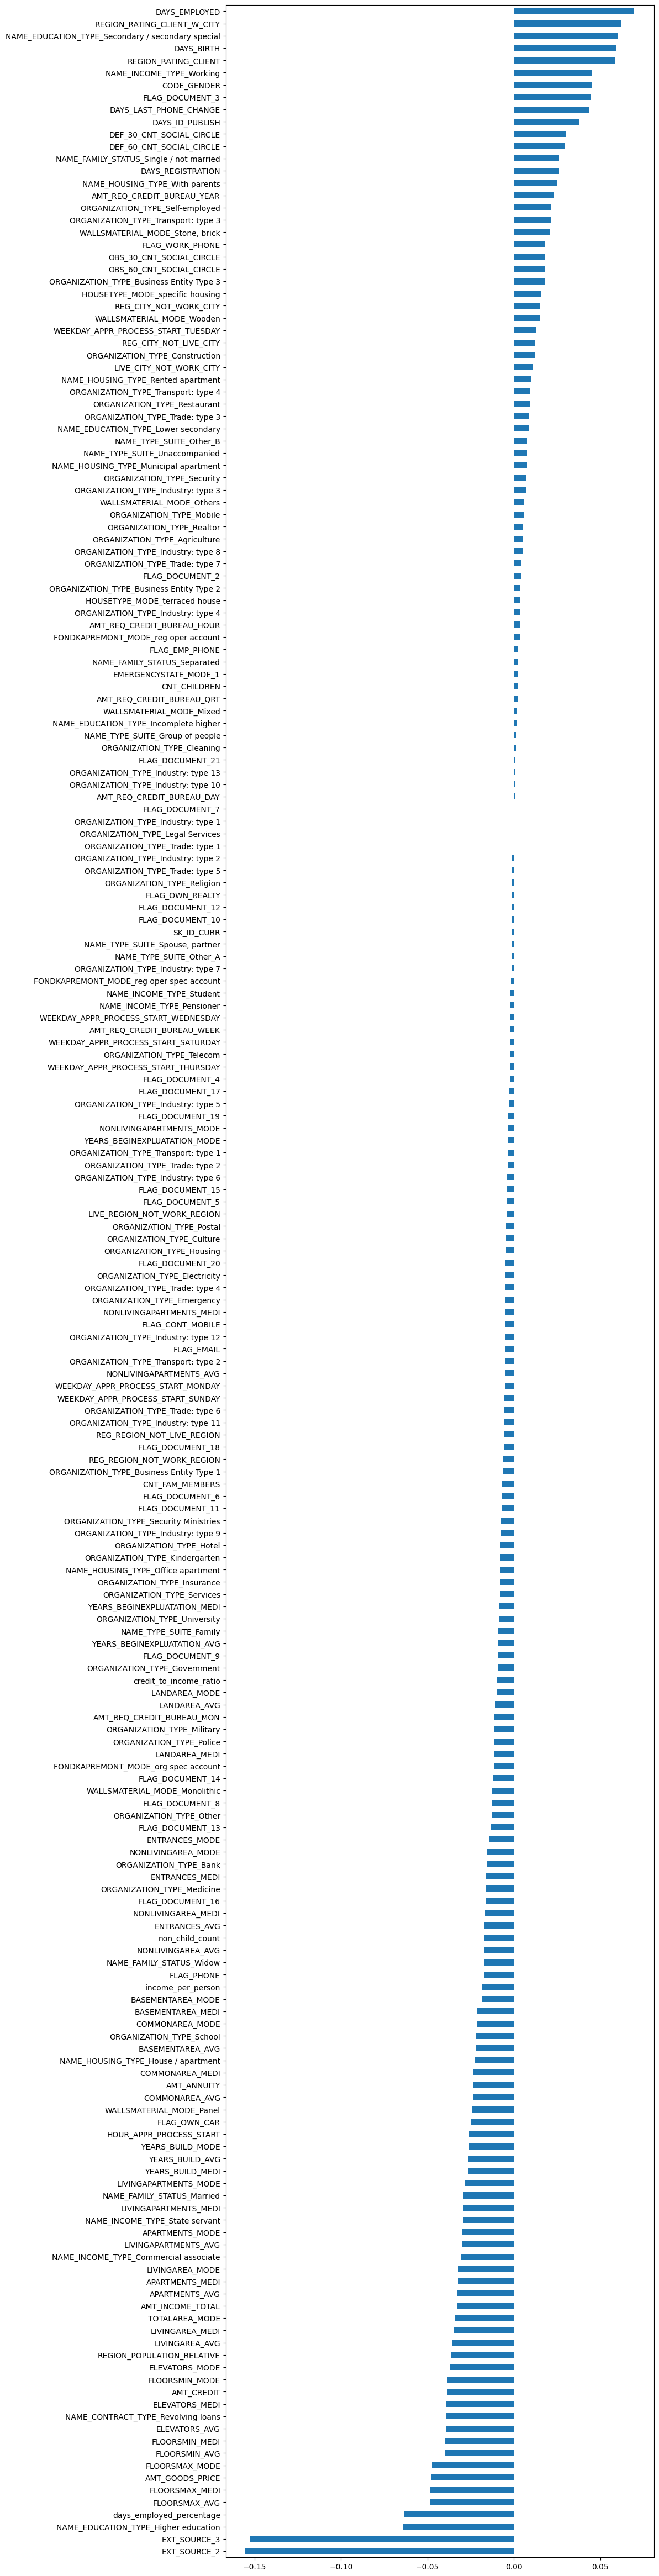

In [ ]:
correlations = df.corr()['TARGET'].sort_values()
correlations.iloc[:-1][:].plot(kind = 'barh', figsize = (10, 60))

Before scaling we can delete ID column as a purely identifying variable.

In [ ]:
train_scaled = df.drop(["SK_ID_CURR"], axis = 1)
test_scaled = test.drop(["SK_ID_CURR"], axis = 1)

Next steps:
- normalization of the data
- applying of PCA in order to reduce dimensionality of the data

## Min-Max Normalization

In [ ]:
for column in train_scaled.columns:
    train_scaled[column] = (train_scaled[column] - train_scaled[column].min()) / (train_scaled[column].max() - train_scaled[column].min())

for column in test_scaled.columns:
    test_scaled[column] = (test_scaled[column] - test_scaled[column].min()) / (test_scaled[column].max() - test_scaled[column].min())

In [ ]:
train_scaled.shape

(71400, 208)

In [ ]:
test_scaled.shape

(11438, 204)

In [ ]:
train_scaled['NAME_INCOME_TYPE_Pensioner']

0         0.0
1         0.0
13        0.0
14        0.0
18        0.0
         ... 
307482    0.0
307489    0.0
307495    0.0
307506    0.0
307508    0.0
Name: NAME_INCOME_TYPE_Pensioner, Length: 71400, dtype: float64

In [ ]:
train_scaled['NAME_INCOME_TYPE_Commercial associate']

0         0.0
1         0.0
13        0.0
14        0.0
18        0.0
         ... 
307482    1.0
307489    1.0
307495    0.0
307506    0.0
307508    0.0
Name: NAME_INCOME_TYPE_Commercial associate, Length: 71400, dtype: float64

In [ ]:
train_scaled['ORGANIZATION_TYPE_Industry: type 8'] # already were removed

0         0.0
1         0.0
13        0.0
14        0.0
18        0.0
         ... 
307482    0.0
307489    0.0
307495    0.0
307506    0.0
307508    0.0
Name: ORGANIZATION_TYPE_Industry: type 8, Length: 71400, dtype: float64

In [ ]:
train_scaled.drop(["NAME_INCOME_TYPE_Commercial associate"], axis = 1, inplace=True)
train_scaled.drop(["NAME_INCOME_TYPE_Pensioner"], axis = 1, inplace=True)
train_scaled.drop(["ORGANIZATION_TYPE_Industry: type 8"], axis = 1, inplace=True)               # to match datasets

test_scaled = test_scaled.replace(np.NaN, 0)
train_scaled = train_scaled.replace(np.NaN, 0)                                       # to fix problem when 0 was changed to NaN by normalization

In [ ]:
train_Y = train_scaled['TARGET']
train_scaled = train_scaled.drop(columns="TARGET")

## PCA

After normalization we apply PCA with minimal number of components that explain mostly all data. Generally, we take 80 components and then plot their cumulative explained variance.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 80)
df_ = pca.fit_transform(train_scaled)

Text(0, 0.5, 'Cumulative explained variance')

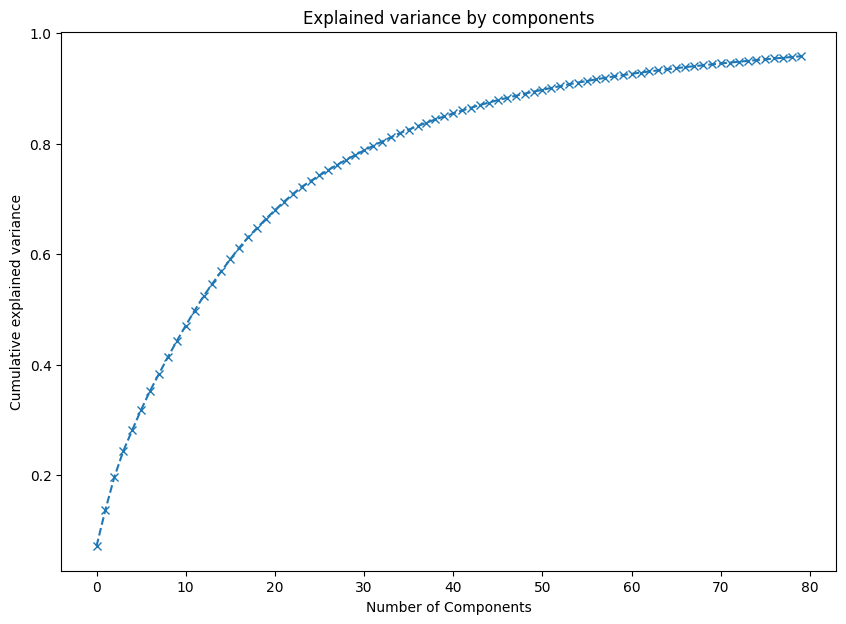

In [ ]:
plt.figure(figsize = (10,7))
plt.plot(range(0,80), pca.explained_variance_ratio_.cumsum(), marker = "x", linestyle = "--")
plt.title("Explained variance by components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative explained variance")

From the plot it can be seen that we need at least 30 to 50 components. Considering 208 features after feature engineering 40 components should be enough to explain 85% of the initial data.

In [ ]:
pca = PCA(n_components = 40)

train_pca = pca.fit_transform(train_scaled)
test_pca = pca.transform(test_scaled)

In [ ]:
train_pca.shape

(71400, 40)

In [ ]:
test_pca.shape

(11438, 40)

To sum up, after feature engineering we ended up with new shapes for train and test datasets:

- before (307511, 122) after (71400, 41)
- before (48744, 121) after (11438, 40)

For purpose of using the same PCA we need equal number of features. So, target variable was separated from train before applying PCA.

# Пункт 4 - Imbalance dataset problem

In [ ]:
train_Y.value_counts()

0.0    66113
1.0     5287
Name: TARGET, dtype: int64

Note that our dataset is very imbalanced: most of the target values are 0. This can hinder the performance of our models. We attempt to resolve this issue using several methods. We will measure the effectiveness of each method with logistic regression score on validation

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_pca, valid_pca, train_Y, valid_Y = train_test_split(train_pca, train_Y, test_size=0.3)

In [ ]:
train_Y.value_counts()

0.0    46279
1.0     3701
Name: TARGET, dtype: int64

## First method: take equal number of observations randomly from train dataset per value of target variable

This method makes the dataset balanced at the expense of the dataset size

In [ ]:
train_pca_with_target = np.hstack((train_pca, train_Y.to_numpy().reshape((train_Y.shape[0], 1))))

In [ ]:
zeros = train_pca_with_target[train_pca_with_target[:,-1] == 0]
ones = train_pca_with_target[train_pca_with_target[:,-1] == 1]

In [ ]:
reduced_zeros = zeros[np.random.choice(zeros.shape[0], ones.shape[0], replace=False), :]

In [ ]:
reduced_train = np.vstack((reduced_zeros, ones))

Right now, first 3699 rows in reduced_train have target 0 and last 3699 rows have target 1. That might affect our model, we will shuffle reduced_train to make target more random

In [ ]:
np.random.shuffle(reduced_train)

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
reduced_train_X = reduced_train[:, 0:-1]

In [ ]:
reduced_train_y = reduced_train[:,-1]

In [ ]:
logreg = LogisticRegression(random_state=33)
logreg.fit(reduced_train_X, reduced_train_y)

LogisticRegression(random_state=33)

In [ ]:
logreg.score(valid_pca, valid_Y)

0.6527077497665733

## Second method: bootstrapping

The difference is that we take a much bigger dataset size by choosing a large number of rows with replacement

In [ ]:
n_bootstrap = 50000
bootstrap_zeros = zeros[np.random.choice(zeros.shape[0], n_bootstrap, replace=True), :]
bootstrap_ones = ones[np.random.choice(ones.shape[0], n_bootstrap, replace=True), :]
bootstrap_train = np.vstack((bootstrap_zeros, bootstrap_ones))
np.random.shuffle(bootstrap_train)
bootstrap_train_X = bootstrap_train[:, 0:-1]
bootstrap_train_y = bootstrap_train[:,-1]
bootstrap_logreg = LogisticRegression(random_state=33)
bootstrap_logreg.fit(bootstrap_train_X, bootstrap_train_y)
bootstrap_logreg.score(valid_pca, valid_Y)

0.6547152194211018

## Third method: upsampling

This time, instead of sampling both the majority and the minority class, we only duplicate the minority class.

In [ ]:
upsampled_ones = ones[np.random.choice(ones.shape[0], zeros.shape[0], replace=True), :]
upsampled_train = np.vstack((zeros, upsampled_ones))
np.random.shuffle(upsampled_train)
upsampled_train_X = upsampled_train[:, 0:-1]
upsampled_train_y = upsampled_train[:,-1]
upsampled_logreg = LogisticRegression(random_state=33)
upsampled_logreg.fit(upsampled_train_X, upsampled_train_y)
upsampled_logreg.score(valid_pca, valid_Y)

0.657469654528478

## Fourth method: Near-Miss algorithms

It's a family of algorithms which attepmt to boost undersampling

Let positive samples be the samples belonging to the targeted class to be under-sampled. Negative sample refers to the samples from the minority class.

NearMiss-1 selects the positive samples for which the average distance to the
N closest samples of the negative class is the smallest.

NearMiss-2 selects the positive samples for which the average distance to the
N farthest samples of the negative class is the smallest.

NearMiss-3 is a 2-steps algorithm. First, for each negative sample, their
M nearest-neighbors will be kept. Then, the positive samples selected are the one for which the average distance to the
N nearest-neighbors is the largest.

N=M=3 by default

In [ ]:
from imblearn.under_sampling import NearMiss

In [ ]:
for v in range(1, 4):
    nm = NearMiss(sampling_strategy=1, version=v)
    X_res, y_res = nm.fit_resample(train_pca, train_Y)
    near_miss_logreg = LogisticRegression(random_state=33)
    near_miss_logreg.fit(X_res, y_res)
    print(near_miss_logreg.score(valid_pca, valid_Y))

0.24201680672268908
0.3141923436041083
0.5510270774976658


Upsampling seems to be the best method

# Пункт 5 - Choosing the appropriate metrics

Before selecting models and fitting them, it is important to choose the appropriate metrics that will be used to evaluate performance of the models and compare them. We have a task of binary classification.

## ROC-AUC

One of stable and powerful metrics to evaluate the performance of a binary classification model is ROC-AUC score. For explaining this metric we need additional notations:

- True Positives(TP) is the number of observations correctly predicted as “0” (will repay loan on time)
- False Positives(FP) is the number of observations wrongly predicted as “1” (will have difficulty repaying loan)
- True Negatives(TN) is the number of observations correctly predicted as “1” (will have difficulty repaying loan)
- False Negatives(FN) is the number of observations wrongly predicted as “0” (will repay loan on time)

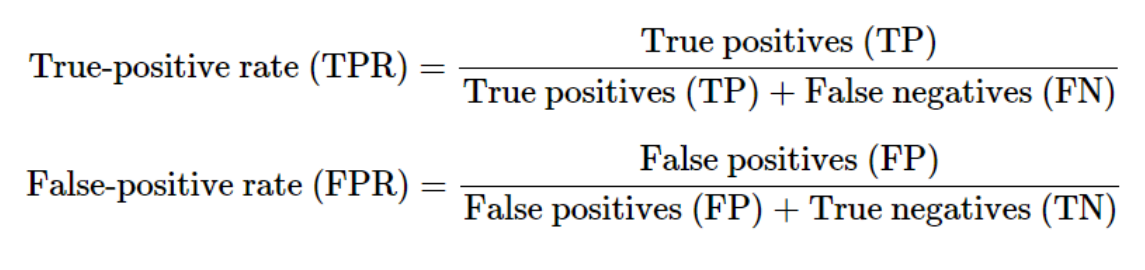

ROC(Receiver Operator Characteristic) curve is a graph that summarizes the performance of a classifier over all possible probability thresholds. ROC curve is generated by plotting a model’s false-positive rate against its true-positive rate across a range of classification thresholds. The ROC- AUC score is basically the area under the ROC curve. The ROC-AUC score varies from 0 to 1: the closer the score is to 1, the better model is considered. ROC curve can be biased for imbalanced datasets. Thus, we may need additional metric that will help to differentiate how good the models’ performances are.

## F1-score

Here we can use F1 metric that assesses the predictive skill of a model by elaborating on its performance by class rather than an overall performance. For explaining this metric we need additional notations:

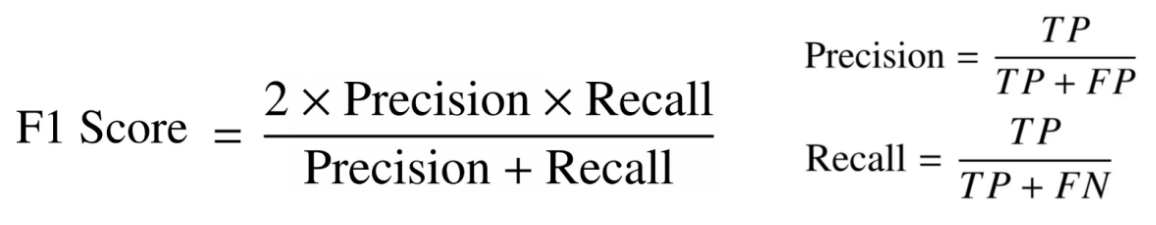

F1 score combines the precision and recall metrics into a single metric. Generally, the F1 score work well on imbalanced datasets. The F1 score varies from 0 to 1: a higher F1 score denotes a better classification model.

# Пункт 6 - Classification Models

ROC-AUC максимизирует точность классификации двух классов. F1-score интерес к конкретному классу.

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from tqdm import trange
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.stats import uniform

## Logistic Regression - Lyu Yuri

Since this is a classification problem, logistic regression will be used as a baseline model. ROC-AUC metric will be used to estimate the quality of predictions. Also, f1 score will be used as an additional metric. But the main metric will be ROC-AUC since our dataset is well-balanced and we want to classify both classes well.

In [ ]:
param_grid = {'C': [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 50, 100],
              "solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', "saga"],
              "class_weight": ['None', 'balanced'],
              'penalty': ['none', 'elasticnet', 'l1', 'l2'],
              "random_state": [42]
              }

log_reg = LogisticRegression()
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 5, random_state = 42)
grid = GridSearchCV(log_reg, param_grid, cv=cv, scoring = 'roc_auc', n_jobs = -1).fit(upsampled_train_X, upsampled_train_y)

print("Best parameters: ", grid.best_params_)
print("Best ROC-AUC score: %.4f" % grid.best_score_)

Best parameters:  {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 42, 'solver': 'saga'}
Best ROC-AUC score: 0.7131


In [ ]:
log_reg = LogisticRegression(penalty='l1', C=0.1, class_weight='balanced', random_state=42, solver='saga').fit(upsampled_train_X, upsampled_train_y)
y_pred = log_reg.predict(valid_pca)

print('Best ROC-AUC score of logistic regression classifier on the test set: {:.4f}'.format(roc_auc_score(valid_Y, y_pred)))
print('Best f1-score of logistic regression classifier on the test set: {:.4f}'.format(f1_score(valid_Y, y_pred)))

Best ROC-AUC score of logistic regression classifier on the test set: 0.6595
Best f1-score of logistic regression classifier on the test set: 0.2226


Cutoff method: to tune threshold value that will classify both classes the best

In [ ]:
fpr, tpr, thresholds = roc_curve(valid_Y, log_reg.predict_proba(valid_pca)[:,1])
gmeans = np.sqrt(tpr + (1-fpr))
ix = np.argmax(gmeans)

print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.498227, G-Mean=1.149


In [ ]:
cutoff = thresholds[ix]
new_predictions = np.where(log_reg.predict_proba(valid_pca)[:,1] > cutoff, 1, 0)
y_pred = [el for el in new_predictions]

print('Best ROC-AUC score of logistic regression classifier on the test set with new threshold: {:.4f}'.format(roc_auc_score(valid_Y, y_pred)))
print('Best f1-score of logistic regression classifier on the test set with new threshold: {:.4f}'.format(f1_score(valid_Y, y_pred)))

Best ROC-AUC score of logistic regression classifier on the test set with new threshold: 0.6600
Best f1-score of logistic regression classifier on the test set with new threshold: 0.2223


In general, best threshold value is not much different from usual value at 0.5 and resulted in almost no change of ROC-AUC score. So, there is no need in threshold tuning.

## LDA - Lyu Yuri

In [ ]:
lda = LinearDiscriminantAnalysis()

param_grid = {'solver': ['svd', 'lsqr', 'eigen'],
              'shrinkage': ['none', 'auto', 0.1, 0.5, 0.9]
              }

cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 5, random_state = 42)
grid_search = GridSearchCV(lda, param_grid, cv=cv, scoring = 'roc_auc', n_jobs = -1).fit(upsampled_train_X, upsampled_train_y)

print("Best parameters: ", grid_search.best_params_)
print("Best ROC-AUC score: %.4f" % grid_search.best_score_)

Best parameters:  {'shrinkage': 'auto', 'solver': 'lsqr'}
Best ROC-AUC score: 0.7184


In [ ]:
lda = LinearDiscriminantAnalysis(solver = "lsqr", shrinkage = "auto").fit(upsampled_train_X, upsampled_train_y)
y_pred = lda.predict(valid_pca)

print('Best ROC-AUC score of LDA on the test set: {:.4f}'.format(roc_auc_score(valid_Y, y_pred)))
print('Best f1-score of LDA on the test set: {:.4f}'.format(f1_score(valid_Y, y_pred)))

Best ROC-AUC score of LDA on the test set: 0.6609
Best f1-score of LDA on the test set: 0.2231


## Random Forest - Golubkova Anna

The random forest is a **classification algorithm** consisting of many decisions trees. It uses bagging and feature randomness when building each individual tree to try to create an uncorrelated forest of trees whose prediction by committee is more accurate than that of any individual tree.

**Random forest**, like its name implies, consists of a large number of individual decision trees that operate as an ensemble. Each individual tree in the random forest spits out a class prediction and the class with the most votes becomes our model’s prediction.


The fundamental concept behind random forest is a simple but powerful one — the wisdom of crowds.



**The reason for this wonderful effect is** that the trees protect each other from their individual errors (as long as they don’t constantly all err in the same direction). While some trees may be wrong, many other trees will be right, so as a group the trees are able to move in the correct direction.

In [ ]:
param_grid = {'n_estimators': [300],
              "max_features": ["sqrt", "log2"],
              "max_depth": [3, 4, 5],
              'criterion': ["gini", "entropy", "log_loss"],
              "random_state": [18]
              }

rf = RandomForestClassifier()
cv = RepeatedStratifiedKFold(n_splits = 4, n_repeats = 5, random_state = 18)
grid = RandomizedSearchCV(rf, param_grid, cv=cv, scoring = 'roc_auc', random_state = 18, n_jobs = -1).fit(upsampled_train_X, upsampled_train_y)

print("Best parameters: ", grid.best_params_)
print("Best ROC-AUC score: %.4f" % grid.best_score_)

Best parameters:  {'random_state': 18, 'n_estimators': 300, 'max_features': 'log2', 'max_depth': 5, 'criterion': 'log_loss'}
Best ROC-AUC score: 0.7370


Let us now check not only ROC-AUC metric but also f1 metric:

In [ ]:
rf = RandomForestClassifier(n_estimators = 300, criterion = 'log_loss', max_features = 'log2', max_depth = 5, random_state = 18).fit(upsampled_train_X, upsampled_train_y)
y_pred = rf.predict(valid_pca)

print('Best ROC-AUC score of random forest classifier on the test set: {:.4f}'.format(roc_auc_score(valid_Y, y_pred)))
print('Best f1-score of random forest classifier on the test set: {:.4f}'.format(f1_score(valid_Y, y_pred)))

Best ROC-AUC score of random forest classifier on the test set: 0.6331
Best f1-score of random forest classifier on the test set: 0.2103


## XGBoost - Golubkova Anna

In [ ]:
param_grid = {'subsample': [0.6, 0.8, 1],
              "colsample_bytree": [0.6, 0.8, 1],
              "max_depth": [3, 4, 5],
              'learning_rate': [0.01, 0.03, 0.1],
              "random_state": [42]
              }

XGB = XGBClassifier()
cv = RepeatedStratifiedKFold(n_splits = 4, n_repeats = 5, random_state = 42)
grid = RandomizedSearchCV(XGB, param_grid, cv=cv, scoring = 'roc_auc', random_state = 42, n_jobs = -1).fit(upsampled_train_X, upsampled_train_y)

print("Best parameters: ", grid.best_params_)
print("Best ROC-AUC score: %.4f" % grid.best_score_)

Best parameters:  {'subsample': 0.8, 'random_state': 42, 'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.6}
Best ROC-AUC score: 0.8055


In [ ]:
XGB = XGBClassifier(subsample = 0.8, colsample_bytree = 0.6, learning_rate = 0.1, max_depth = 4, random_state = 42).fit(upsampled_train_X, upsampled_train_y)
y_pred = XGB.predict(valid_pca)

print('Best ROC-AUC score of XGBoost classifier on the test set: {:.4f}'.format(roc_auc_score(valid_Y, y_pred)))
print('Best f1-score of XGBoost classifier on the test set: {:.4f}'.format(f1_score(valid_Y, y_pred)))

Best ROC-AUC score of XGBoost classifier on the test set: 0.6428
Best f1-score of XGBoost classifier on the test set: 0.2222


## Support Vector Machine - Жухлистов Станислав

We tune hyperparameters using score on validation.

Sklearn documentation suggests to prefer dual=False on datasets where n_samples > n_features which is the case on our dataset.

We tune c (a regularisation parameter) and tol (tolerance for stopping) using logarithmic grid.

Other hyperparameters cannot be changed

In [ ]:
c = 1e-7
best_c = 0
best_tol = 0
best_score = 0
for _ in trange(10):
  tol = 1e-8
  for _ in range(7):
    svm = LinearSVC(dual=False, C=c, tol=tol, random_state=33)
    svm.fit(upsampled_train_X, upsampled_train_y)
    curr_score = roc_auc_score(valid_Y, svm.predict(valid_pca))
    if curr_score > best_score:
      best_score = curr_score
      best_c = c
      best_tol = tol
    tol *= 10
  c *= 10
best_c, best_tol, best_score

100%|██████████| 10/10 [00:53<00:00,  5.35s/it]


(0.1, 0.001, 0.6600906375374626)

In [ ]:
svm = LinearSVC(dual=False, C=best_c, tol=best_tol, random_state=33).fit(upsampled_train_X, upsampled_train_y)
y_pred = svm.predict(valid_pca)

print('Best ROC-AUC score of SVM classifier on the test set: {:.4f}'.format(roc_auc_score(valid_Y, y_pred)))
print('Best f1-score of SVM classifier on the test set: {:.4f}'.format(f1_score(valid_Y, y_pred)))

Best ROC-AUC score of SVM classifier on the test set: 0.6601
Best f1-score of SVM classifier on the test set: 0.2227


## Naive Bayes - Shirshov Konstantin

In [ ]:
NB = BernoulliNB()

param_grid = {'alpha': np.logspace(-3, 0, 20),
              'binarize': np.linspace(0.0, 1.0, 10),
              'fit_prior': [True, False]
              }

cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 5, random_state = 42)
grid = GridSearchCV(NB, param_grid, cv=cv, scoring = 'roc_auc', n_jobs = -1).fit(upsampled_train_X, upsampled_train_y)

print("Best parameters: ", grid.best_params_)
print("Best ROC-AUC score: %.4f" % grid.best_score_)

Best parameters:  {'alpha': 0.1623776739188721, 'binarize': 0.1111111111111111, 'fit_prior': True}
Best ROC-AUC score: 0.6842


In [ ]:
NB = BernoulliNB(alpha=0.1623776739188721, binarize=0.1111111111111111, fit_prior=True).fit(upsampled_train_X, upsampled_train_y)
y_pred = NB.predict(valid_pca)

print('Best ROC-AUC score of Bernoulli Naive Bayes classifier on the test set: {:.4f}'.format(roc_auc_score(valid_Y, y_pred)))
print('Best f1-score of Bernoulli Naive Bayes classifier on the test set: {:.4f}'.format(f1_score(valid_Y, y_pred)))

Best ROC-AUC score of Bernoulli Naive Bayes classifier on the test set: 0.6188
Best f1-score of Bernoulli Naive Bayes classifier on the test set: 0.1958


# Пункт 7 - Comparison of models. Practical value and realization in business.

In [ ]:
models = [LogisticRegression(penalty='l1', C=0.1, class_weight='balanced', random_state=42, solver='saga'),
          LinearDiscriminantAnalysis(solver = "lsqr", shrinkage = "auto"),
          RandomForestClassifier(n_estimators = 300, criterion = 'log_loss', max_features = 'log2', max_depth = 5, random_state = 18),
          XGBClassifier(subsample = 0.8, colsample_bytree = 0.6, learning_rate = 0.1, max_depth = 4, random_state = 42),
          LinearSVC(dual=False, C=best_c, tol=best_tol, random_state=33),
          BernoulliNB(alpha=0.1623776739188721, binarize=0.1111111111111111, fit_prior=True)]  # list of models for simple fit
models_names = ["LogisticRegression", "LDA", "RandomForestClassifier", "XGBoostClassifier", "LinearSVC", "BernoulliNB"]
table = []
for i in range(6):
    models[i].fit(upsampled_train_X, upsampled_train_y)

    train_pred = models[i].predict(upsampled_train_X)
    test_pred = models[i].predict(valid_pca)

    row = [models_names[i], round(roc_auc_score(upsampled_train_y, train_pred), 4), round(roc_auc_score(valid_Y, test_pred),4), \
                  round(f1_score(upsampled_train_y, train_pred),4), round(f1_score(valid_Y, test_pred),4)]
    table.append(row)

print(tabulate(table, headers=["Model","train ROC-AUC","test ROC-AUC","train F1 score","test F1 score"], tablefmt="orgbtl"))

Model                     train ROC-AUC    test ROC-AUC    train F1 score    test F1 score
----------------------  ---------------  --------------  ----------------  ---------------
LogisticRegression               0.6631          0.6595            0.6649           0.2226
LDA                              0.6629          0.6609            0.6652           0.2231
RandomForestClassifier           0.6842          0.6331            0.6822           0.2103
XGBoostClassifier                0.7431          0.6428            0.7469           0.2222
LinearSVC                        0.6638          0.6601            0.6661           0.2227
BernoulliNB                      0.6428          0.6188            0.6413           0.1958


After fitting the models and hyperparameter tuning, we conclude that LDA is the best model based on validation on the test dataset. However, Logistic Regression and Support Vector Machine Classifier also performed well.

Even though LDA showed the best performance, it was decided to choose Logistic Regression as our final model due minor difference between models and its simplicity(relatively easy to operate and maintain).

We propose the following usage of the model for the real world tasks: the model makes a decision to give a loan depending on the information received by employees of the bank from a client. Maintenance of the model will be done with constant data updates and further improvements of model’s prediction.